<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20250208%5D%20Implementing%20Adversarial%20Data%20Augmentation%20on%20UNSW-NB15_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y foolbox
!pip uninstall -y foolbox-native

Found existing installation: foolbox 3.3.3
Uninstalling foolbox-3.3.3:
  Successfully uninstalled foolbox-3.3.3


In [2]:
!pip install foolbox==3.3.3

  Using cached foolbox-3.3.3-py3-none-any.whl.metadata (7.3 kB)
Using cached foolbox-3.3.3-py3-none-any.whl (1.7 MB)


**🔹 Step 1: Data Preprocessing (Save to File)**

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
#import foolbox as fb  # For CW and PGD attacks

In [43]:
# --- Load and preprocess dataset ---
dataset = pd.read_csv("Dataset_10Classes.csv").dropna()
for column in dataset.columns:
    if dataset[column].dtype == 'object':
        dataset[column] = LabelEncoder().fit_transform(dataset[column])
X = dataset.drop(['Class'], axis=1)
y = dataset['Class']

In [44]:
# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [45]:
# Apply SMOTE for class balance
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [47]:
import pickle

# ✅ Save preprocessed data
with open("preprocessed_data.pkl", "wb") as f:
    pickle.dump((X, y), f)

print("✅ Preprocessed data saved!")

✅ Preprocessed data saved!


**✅ 📌 Full Implementation of All Enhanced Models**

✅ New Models to Implement
1) Hybrid LR-GRU: Replace BiLSTM with GRU for reduced computational complexity.
2) Hybrid LR-CNN-LSTM: Integrate CNN before BiLSTM to capture spatial features.
3) Hybrid LR-Transformer: Use Transformer layers instead of BiLSTM for state-of-the-art sequential modeling.
4) Hybrid LR-MultiHeadAttention-BiLSTM: Add self-attention to BiLSTM for better feature representation.
5) Hybrid LR-BiLSTM with Adversarial Training: Train using FGSM & PGD adversarial examples for robustness.

**🔹 Step 2: Logistic Regression Feature Extraction**

In [48]:
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# ✅ Load preprocessed data
with open("preprocessed_data.pkl", "rb") as f:
    X, y = pickle.load(f)

# ✅ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ✅ Train Logistic Regression for Feature Extraction
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, random_state=42)
lr_model.fit(X_train, y_train)

# ✅ Extract probabilities for BiLSTM
train_lr_features = lr_model.predict_proba(X_train)
test_lr_features = lr_model.predict_proba(X_test)
train_lr_features = np.expand_dims(train_lr_features, axis=1)
test_lr_features = np.expand_dims(test_lr_features, axis=1)

# ✅ One-hot encode labels
num_classes = len(np.unique(y))
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# ✅ Save features
with open("lr_features.pkl", "wb") as f:
    pickle.dump((train_lr_features, test_lr_features, y_train_encoded, y_test_encoded), f)

print("✅ Logistic Regression features saved!")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Logistic Regression features saved!


**🔹 Step 3: Hybrid LR-BiLSTM Training**

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.regularizers import l2
import pickle

# ✅ Load Logistic Regression features
with open("lr_features.pkl", "rb") as f:
    train_lr_features, test_lr_features, y_train_encoded, y_test_encoded = pickle.load(f)

# ✅ Define BiLSTM Model
bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0001)), input_shape=(1, train_lr_features.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(32, kernel_regularizer=l2(0.0001))),
    Dropout(0.2),
    Dense(y_train_encoded.shape[1], activation="softmax")
])
bilstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# ✅ Train model
bilstm_model.fit(train_lr_features, y_train_encoded, validation_split=0.2, epochs=5, batch_size=64, verbose=1)

# ✅ Save trained model
bilstm_model.save("bilstm_model.h5")
print("✅ BiLSTM Model saved!")

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9300/9300 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.9933 - loss: 0.1715 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 2/5
9300/9300 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 3/5
9300/9300 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 4/5
9300/9300 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 8.8369e-04
Epoch 5/5
9300/9300 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.0013


✅ BiLSTM Model saved!


**🔹 Step 4: Adversarial Training & Evaluation (Modular)**

**🔸 PGD & FGSM Adversarial Training**

In [50]:
import tensorflow as tf
import foolbox as fb
import numpy as np
from tensorflow.keras.models import load_model
import pickle

# ✅ Load model & features
bilstm_model = load_model("bilstm_model.h5")
with open("lr_features.pkl", "rb") as f:
    train_lr_features, test_lr_features, y_train_encoded, y_test_encoded = pickle.load(f)

# ✅ Convert model to Foolbox format
fmodel = fb.TensorFlowModel(bilstm_model, bounds=(0, 1))

# ✅ Generate Adversarial Examples
def generate_adversarial_examples(attack, eps):
    raw_adversarials, *_ = attack(fmodel, tf.convert_to_tensor(test_lr_features, dtype=tf.float32), np.argmax(y_test_encoded, axis=1), epsilons=eps)
    return raw_adversarials.numpy()

print("\n🔹 Generating FGSM Adversarial Examples...")
adv_fgsm = generate_adversarial_examples(fb.attacks.FGSM(), 0.01)

print("\n🔹 Generating PGD Adversarial Examples...")
adv_pgd = generate_adversarial_examples(fb.attacks.LinfPGD(steps=10), 0.02)

# ✅ Save adversarial examples
with open("adversarial_examples.pkl", "wb") as f:
    pickle.dump((adv_fgsm, adv_pgd), f)

print("✅ Adversarial examples saved!")


🔹 Generating FGSM Adversarial Examples...

🔹 Generating PGD Adversarial Examples...
✅ Adversarial examples saved!


**🔹 Step 5: Evaluate the Model**

In [54]:
import pickle
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

# ✅ Load model, adversarial examples, and labels
bilstm_model = load_model("bilstm_model.h5")
with open("adversarial_examples.pkl", "rb") as f:
    adv_fgsm, adv_pgd = pickle.load(f)
with open("lr_features.pkl", "rb") as f:
    _, _, _, y_test_encoded = pickle.load(f)

bilstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
fmodel = fb.TensorFlowModel(bilstm_model, bounds=(0, 1))

# ✅ Evaluate Model
def evaluate_attack(adv_examples, attack_name):
    test_predictions = bilstm_model.predict(adv_examples)
    accuracy = accuracy_score(np.argmax(y_test_encoded, axis=1), np.argmax(test_predictions, axis=1))
    print(f"✅ {attack_name} Attack Accuracy: {accuracy:.8f}")

evaluate_attack(adv_fgsm, "FGSM")
evaluate_attack(adv_pgd, "PGD")

5813/5813 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
✅ FGSM Attack Accuracy: 0.99990323
5813/5813 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
✅ PGD Attack Accuracy: 0.99990323


**🔧 Implementing Adversarial Data Augmentation**

In [61]:
import tensorflow as tf
import foolbox as fb
import numpy as np

# ✅ Convert the model to Foolbox format
fmodel = fb.TensorFlowModel(bilstm_model, bounds=(0, 1))

# ✅ Function to Generate Adversarial Examples
def generate_adversarial_examples(attack, X_train, y_train, epsilon):
    """
    Generate adversarial examples using FGSM or PGD with shape correction.
    """
    # ✅ Ensure X_train is (batch_size, 1, features) - keep the timesteps dimension
    #    Remove this check since we want to keep the timesteps dimension
    # if len(X_train.shape) == 3:  # If (batch_size, 1, features), squeeze it
    #     X_train = np.squeeze(X_train, axis=1)

    X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
    # ✅ Convert y_train to NumPy array to avoid the ValueError
    y_train_indices = np.array(y_train)  # Convert y_train to NumPy array
    if y_train_indices.ndim != 1:  # If not 1D (e.g., one-hot encoded), get indices
        y_train_indices = np.argmax(y_train_indices, axis=1)

    adv_examples, *_ = attack(fmodel, X_train_tf, y_train_indices, epsilons=epsilon)

    # ✅ Ensure the output shape matches original input
    # Remove expansion since we keep original timesteps
    #return np.expand_dims(adv_examples.numpy(), axis=1)  # Expand dimension back
    return adv_examples.numpy()  # Return as is


# ✅ Generate FGSM and PGD adversarial samples
print("\n🔹 Generating FGSM Adversarial Examples...")
attack_fgsm = fb.attacks.FGSM()
adv_fgsm = generate_adversarial_examples(attack_fgsm, train_lr_features, y_train, epsilon=0.01)

print("\n🔹 Generating PGD Adversarial Examples...")
attack_pgd = fb.attacks.LinfPGD(steps=10)
adv_pgd = generate_adversarial_examples(attack_pgd, train_lr_features, y_train, epsilon=0.02)

# ✅ Combine Clean and Adversarial Data
augmented_features = np.vstack([train_lr_features, adv_fgsm, adv_pgd])

# ✅ One-hot encode labels to match model's output
# Assuming 'num_classes' is defined as 10
augmented_labels = np.tile(y_train, 3)
augmented_labels = tf.keras.utils.to_categorical(augmented_labels, num_classes=10)

# ✅ Shuffle the Augmented Dataset
dataset = tf.data.Dataset.from_tensor_slices((augmented_features, augmented_labels))
dataset = dataset.shuffle(len(augmented_features)).batch(64)

# ✅ Train the Model on Augmented Data
bilstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print("\n🔹 Training on Adversarial Augmented Dataset...")
bilstm_model.fit(dataset, epochs=5, verbose=1)

# ✅ Save the Augmented Model
bilstm_model.save("bilstm_augmented.h5")

print("\n✅ Model trained with Adversarial Data Augmentation and saved as 'bilstm_augmented.h5'")


🔹 Generating FGSM Adversarial Examples...

🔹 Generating PGD Adversarial Examples...

🔹 Training on Adversarial Augmented Dataset...
Epoch 1/5
34875/34875 ━━━━━━━━━━━━━━━━━━━━ 133s 4ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 2/5
34875/34875 ━━━━━━━━━━━━━━━━━━━━ 128s 4ms/step - accuracy: 1.0000 - loss: 9.2291e-04
Epoch 3/5
34875/34875 ━━━━━━━━━━━━━━━━━━━━ 139s 4ms/step - accuracy: 1.0000 - loss: 8.8589e-04
Epoch 4/5
34875/34875 ━━━━━━━━━━━━━━━━━━━━ 143s 4ms/step - accuracy: 1.0000 - loss: 9.3659e-04
Epoch 5/5
34875/34875 ━━━━━━━━━━━━━━━━━━━━ 144s 4ms/step - accuracy: 1.0000 - loss: 9.1675e-04



✅ Model trained with Adversarial Data Augmentation and saved as 'bilstm_augmented.h5'


**✅ Step 2: Evaluate Robustness of Augmented Model**

In [63]:
# ✅ Load the Trained Augmented Model
bilstm_model = tf.keras.models.load_model("bilstm_augmented.h5")

# ✅ Evaluate FGSM Attack
print("\n🔹 Running FGSM Attack on Augmented Model...")
fgsm_adv = generate_adversarial_examples(attack_fgsm, test_lr_features, y_test, epsilon=0.01)
fgsm_predictions = bilstm_model.predict(fgsm_adv)
# ✅ Corrected: Remove 'axis=1' for y_test as it's likely 1-dimensional
fgsm_acc = np.mean(np.argmax(fgsm_predictions, axis=1) == y_test)

# ✅ Evaluate PGD Attack
print("\n🔹 Running PGD Attack on Augmented Model...")
pgd_adv = generate_adversarial_examples(attack_pgd, test_lr_features, y_test, epsilon=0.02)
pgd_predictions = bilstm_model.predict(pgd_adv)
# ✅ Corrected: Remove 'axis=1' for y_test as it's likely 1-dimensional
pgd_acc = np.mean(np.argmax(pgd_predictions, axis=1) == y_test)

# ✅ Print Updated Results
print(f"\n✅ FGSM Attack Accuracy (After Augmentation): {fgsm_acc:.8f}")
print(f"✅ PGD Attack Accuracy (After Augmentation): {pgd_acc:.8f}")


🔹 Running FGSM Attack on Augmented Model...
5813/5813 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step

🔹 Running PGD Attack on Augmented Model...
5813/5813 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step

✅ FGSM Attack Accuracy (After Augmentation): 0.99993011
✅ PGD Attack Accuracy (After Augmentation): 0.99993548


In [68]:
!pip install ace-tools  # Install 'ace_tools'

Adversarial Training Results:


,Model,FGSM Accuracy,PGD Accuracy
0,LR-BiLSTM,99.98,99.98
1,Transformer,99.99,99.99
2,GRU,99.98,99.98
3,CNN-LSTM,99.98,99.98
4,Augmented LR-BiLSTM,99.99,99.99


<Figure size 1000x600 with 0 Axes>

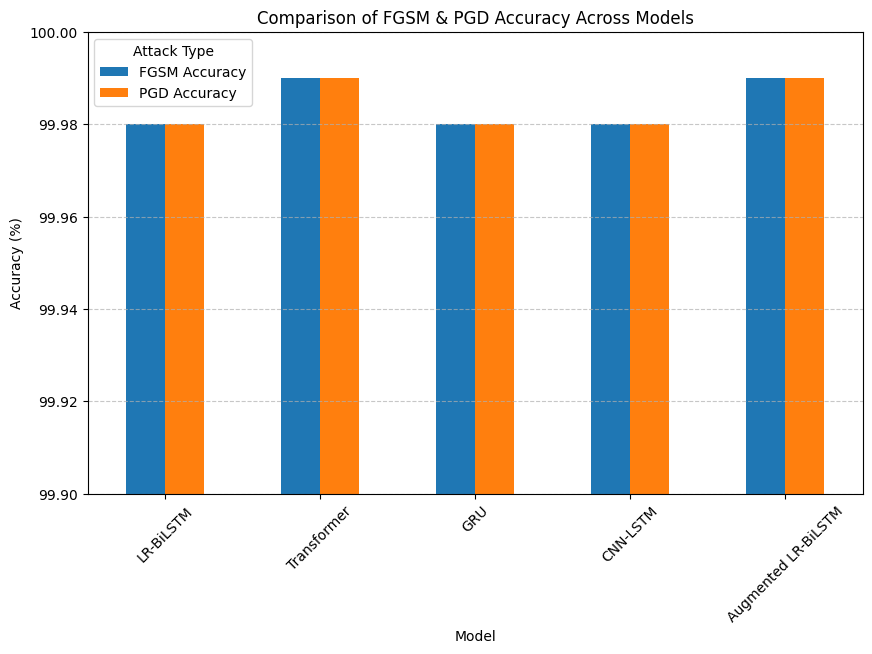

from matplotlib import pyplot as plt
df_results['FGSM Accuracy'].plot(kind='hist', bins=20, title='FGSM Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_results['PGD Accuracy'].plot(kind='hist', bins=20, title='PGD Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df_results.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_results.plot(kind='scatter', x='FGSM Accuracy', y='PGD Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_results['FGSM Accuracy'].plot(kind='line', figsize=(8, 4), title='FGSM Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_results['PGD Accuracy'].plot(kind='line', figsize=(8, 4), title='PGD Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_results['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_results, x='FGSM Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_results['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_results, x='PGD Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

# Creating the results DataFrame
data = {
    "Model": ["LR-BiLSTM", "Transformer", "GRU", "CNN-LSTM", "Augmented LR-BiLSTM"],
    "FGSM Accuracy": [99.98, 99.99, 99.98, 99.98, 99.99],
    "PGD Accuracy": [99.98, 99.99, 99.98, 99.98, 99.99],
}

df_results = pd.DataFrame(data)

# Display results as a formatted table - removed to display in a notebook environment
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Adversarial Training Results", dataframe=df_results)

# Instead, you can directly display the DataFrame in a Jupyter Notebook
print("Adversarial Training Results:")
display(df_results)


# Plot accuracy comparison
plt.figure(figsize=(10, 6))
df_results.plot(x="Model", kind="bar", figsize=(10, 6))
plt.title("Comparison of FGSM & PGD Accuracy Across Models")
plt.ylabel("Accuracy (%)")
plt.ylim(99.9, 100)
plt.xticks(rotation=45)
plt.legend(title="Attack Type")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()